In [1]:
#Plotting Library
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.datasets import load_gunpoint

#Data Manipulation Library
import pandas as pd
import numpy as np

#Runtime Library
from tqdm import tqdm

#Data Preprocessing Libraries
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
####-------------------- Full Kaggle Dataset Import ------------------------------------####

In [3]:
## This is the path of the CNN Input Folder ##
mypath = '/Users/jakob/OneDrive - Universitat Ramón Llull/TechLabsProj/cnn_input'

In [4]:
price_data = pd.read_csv(f'{mypath}/cnn_fullpriceinput.csv')
price_data.drop(['Unnamed: 0'], axis=1, inplace=True)
price_data.dropna(axis=0, inplace=True)

In [5]:
price_data

,rsi,bb_upper,bb_mid,bb_lower,aroonup,aroondown,PVT,pvt_movmean,pvt_signal,AB_Middle_Band,...,typical_price,raw_money_flow,shifted_raw_money_flow,turning_line,std_line,leading_span_1,leading_span_2,%R,return,return_pred
0,0.734637,0.003998,0.004153,0.411264,0.833333,0.208333,0.515338,0.505641,0.0,0.004526,...,0.004905,0.008422,0.008689,0.005200,0.004819,0.002834,0.002516,0.562993,-0.075627,-0.075257
1,0.765068,0.004043,0.004244,0.411335,0.791667,0.166667,0.515315,0.505512,0.0,0.004617,...,0.004618,0.010633,0.008422,0.005200,0.004819,0.002834,0.002520,0.362688,-0.075257,-0.058742
2,0.739698,0.004068,0.004320,0.411406,0.750000,0.125000,0.515391,0.505509,1.0,0.004682,...,0.004364,0.008690,0.010633,0.005248,0.004819,0.002856,0.002520,0.250883,-0.058742,0.033363
3,0.724590,0.004082,0.004382,0.411472,0.708333,0.083333,0.515483,0.505747,1.0,0.004757,...,0.004333,0.007844,0.008690,0.005387,0.004819,0.002901,0.002566,0.310653,0.033363,0.025961
4,0.700270,0.004100,0.004448,0.411538,0.666667,0.041667,0.515322,0.505789,0.0,0.004806,...,0.004495,0.004594,0.007844,0.005368,0.004819,0.002901,0.002577,0.326371,0.025961,-0.060846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259953,0.555336,0.004384,0.006774,0.414243,0.875000,0.000000,0.515342,0.505697,0.0,0.006887,...,0.006217,0.013820,0.010704,0.006716,0.006829,0.006409,0.006879,0.349606,-0.009185,-0.018366
259954,0.572706,0.004380,0.006786,0.414263,0.833333,0.041667,0.515338,0.505685,0.0,0.006883,...,0.006159,0.011043,0.013820,0.006708,0.006843,0.006409,0.006879,0.060332,-0.018366,-0.008197
259955,0.496411,0.004373,0.006793,0.414279,0.791667,0.000000,0.515362,0.505707,1.0,0.006877,...,0.006068,0.010913,0.011043,0.006662,0.006843,0.006418,0.006901,0.128580,-0.008197,0.012846
259956,0.513695,0.004368,0.006799,0.414293,0.750000,0.000000,0.515386,0.505739,1.0,0.006873,...,0.006108,0.016603,0.010913,0.006662,0.006868,0.006424,0.006939,0.302864,0.012846,-0.001419


In [6]:
####-------------------- Additional Fake Features ------------------------------------####

In [7]:
def fill_up_features_count(feature_list):
    """
    Every feature is later plotted as a smaller square embedded in a larger square. Therefore the number of features
    needs to have an integer square root.
    
    Based on the imported technicals this function checks how many 'mock features' need to be added
    to make the plotting possible.
    """
    number_of_target_features = 2
    
    feature_count = len(feature_list)-number_of_target_features #- #targets
    
    while (np.sqrt(feature_count)).is_integer() == False:
        feature_count = feature_count +1
    
    to_fill = feature_count - (len(feature_list) -1) #-1 for return feature (target)
    return (feature_count, to_fill)

to_fill = fill_up_features_count(price_data.columns)

In [8]:
def fill_up_features(price_data, to_fill):
    """
    This function adds the computed number of mock features as null columns to the dataset.
    """
    for i in range(0, to_fill[1]):
        price_data[f'mock_{i}'] = 0
    
    return price_data

price_data = fill_up_features(price_data, to_fill)

In [9]:
####------------------ Distributing & Exporting Train & Test Dataset ------------------####

In [10]:
## Train & Test Set for same day return estimation ##

df = price_data.drop('return_pred', axis=1)
list_features = list(df.iloc[:, :-1].columns)
print('Total number of features', len(list_features))

#define return column as target & split in x/y & train/test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1].values, df['return'].values, train_size=0.8, 
                                                    test_size=0.2, random_state=2, shuffle=True)

Total number of features 36


In [12]:
y_train

array([-0.01363884, -0.01501104,  0.0145856 , ...,  0.00840336,
       -0.04656319, -0.00454047])

In [105]:
#export target variable as csv for further processing
pd.DataFrame(y_train).to_csv(f'{mypath}/y_train.csv', index_label=False)
pd.DataFrame(y_test).to_csv(f'{mypath}/y_test.csv', index_label=False)

In [106]:
## Train & Test Set for next day return prediction ##

df = price_data.drop('return', axis=1)
list_features = list(df.iloc[:, :-1].columns)
print('Total number of features', len(list_features))

#define return column as target & split in x/y & train/test
x_train_pred, x_test_pred, y_train_pred, y_test_pred = train_test_split(df.iloc[:, :-1].values, df['return_pred'].values, train_size=0.8, 
                                                    test_size=0.2, random_state=2, shuffle=True)

Total number of features 36


In [107]:
#export target variable as csv for further processing
pd.DataFrame(y_train_pred).to_csv(f'{mypath}/y_train_pred.csv', index_label=False)
pd.DataFrame(y_test_pred).to_csv(f'{mypath}/y_test_pred.csv', index_label=False)

In [91]:
####-------------------- Imaging Data as pyplot ------------------------------------####

In [108]:
def image_format(x, img_width, img_height):
    '''
    Function formats the features in a matrix that can be plotted (as square) later.
    1st Step: Creating a list of null arrays each with the dimensions dimXdim as basis to fill.
    2nd Step: Each datapoint (technicals per day) is iterated as list of values & reshaped in a dimXdim matrix which replaced the 0 matrix.
    '''
    x_temp = np.zeros((len(x), img_height, img_width)) #creating array of zeros as basis (shape given as lengthXheightXwidth)
    for i in range(x.shape[0]): #iterating rows of input
        x_temp[i] = np.reshape(x[i], (img_height, img_width)) #each row is iterated as list of values 
    return x_temp

In [109]:
def shaping(list_features, x_mat):
    #compute the side length of the plotted squares
    dim = int(np.sqrt(len(list_features))) #sqrt in order to fit the quadratic plot sturcture (sqrt of number of features needs to be an integer)

    #transforming tabular data to be plotted
    x_mat = image_format(x_mat, dim, dim)

    # adding 1 additional dimension (containing 3 times each value to represent color)
    x_mat = np.stack((x_mat,) * 3, axis=-1)
    
    return x_mat

In [110]:
def convert_to_img(input_matrix, name, y_mat, labelling_type):
    """
    This function is converting the data into images:
    1. Plot the shaped matrix as square of smaller squares.
    2. Sorting every image on label (return positive or negative).
    3. Saving the image in the respective folder.
    """
    for i in tqdm(range(0, len(input_matrix))): #iterating all rows
        img = input_matrix[i]
        plt.imshow(img) # drawing matrix as a 2d plot/ as image
        plt.axis("off")
        plt.title(f'{name}_index_{str(i)}', fontsize=10)
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        
        if y_mat[i] > 0: 
            plt.savefig(f'{mypath}/{labelling_type}/{name}/pos/{name}_index_{str(i)}.png')
        else:
            plt.savefig(f'{mypath}/{labelling_type}/{name}/neg/{name}_index_{str(i)}.png')
        
        plt.close('all')
    return

In [116]:
def function_call(x_mat, y_mat, dataset, call_type, list_features=list_features):
    '''
    This function calls the shaping as well as image transformation function. Hereby it takes the x arrays as input.
    The function enables to choose between same day estimation and next day prediciton mode.
    Depending on the selection the target path is adapted.
    The x input array and call_type arg need to be changed manually depending on the preference.
    '''
    ## call the shaping function with chosen x input ##
    x_mat = shaping(list_features, x_mat) 
    
    ## check if next day prediction or same daxy estimation to adapt target path ## 
    if call_type == 'pred':
        convert_to_img(x_mat, f'x_{dataset}', y_mat, labelling_type='pyplot_labelling_prediction')
    
    elif call_type == 'est':
        convert_to_img(x_mat, f'x_{dataset}', y_mat, labelling_type='pyplot_labelling')
    
    return

In [117]:
#function_call(x_train, y_train, dataset='train', call_type='est')

In [ ]:
#function_call(x_test, y_test, dataset='test', call_type='est')





  0%|          | 0/207966 [00:00<?, ?it/s]



  0%|          | 5/207966 [00:00<1:24:37, 40.96it/s]



  0%|          | 9/207966 [00:00<1:25:51, 40.37it/s]



  0%|          | 13/207966 [00:00<1:26:57, 39.86it/s]



  0%|          | 18/207966 [00:00<1:25:14, 40.66it/s]



  0%|          | 23/207966 [00:00<1:25:14, 40.66it/s]



  0%|          | 27/207966 [00:00<1:27:11, 39.75it/s]



  0%|          | 31/207966 [00:00<1:28:02, 39.36it/s]



  0%|          | 35/207966 [00:00<1:28:49, 39.01it/s]



  0%|          | 39/207966 [00:00<1:28:55, 38.97it/s]



  0%|          | 43/207966 [00:01<1:29:48, 38.59it/s]



  0%|          | 47/207966 [00:01<1:29:16, 38.82it/s]



  0%|          | 52/207966 [00:01<1:26:11, 40.20it/s]



  0%|          | 57/207966 [00:01<1:23:42, 41.40it/s]



  0%|          | 62/207966 [00:01<1:22:25, 42.04it/s]



  0%|          | 67/207966 [00:01<1:22:27, 42.02it/s]



  0%|          | 72/207966 [00:01<1:22:04, 42.22it/s]



  0%|          | 77/207966 [00:01<1:22:3

  1%|          | 1055/207966 [00:33<1:20:22, 42.90it/s]



  1%|          | 1060/207966 [00:33<1:24:11, 40.96it/s]



  1%|          | 1065/207966 [00:33<1:24:58, 40.58it/s]



  1%|          | 1070/207966 [00:33<1:24:32, 40.79it/s]



  1%|          | 1075/207966 [00:33<1:23:08, 41.47it/s]



  1%|          | 1080/207966 [00:33<1:21:13, 42.46it/s]



  1%|          | 1085/207966 [00:33<1:24:09, 40.97it/s]



  1%|          | 1090/207966 [00:34<1:24:29, 40.81it/s]



  1%|          | 1095/207966 [00:34<1:22:51, 41.61it/s]



  1%|          | 1100/207966 [00:34<1:22:42, 41.68it/s]



  1%|          | 1105/207966 [00:34<1:21:26, 42.33it/s]



  1%|          | 1110/207966 [00:34<1:20:54, 42.61it/s]



  1%|          | 1115/207966 [00:34<1:23:49, 41.13it/s]



  1%|          | 1120/207966 [00:34<1:23:40, 41.20it/s]



  1%|          | 1125/207966 [00:34<1:23:18, 41.38it/s]



  1%|          | 1130/207966 [00:35<1:23:06, 41.48it/s]



  1%|          | 1135/207966 [00:35<1:22:00, 42.04it/s]


  1%|          | 2172/207966 [01:02<1:21:50, 41.91it/s]



  1%|          | 2177/207966 [01:02<1:21:47, 41.93it/s]



  1%|          | 2182/207966 [01:02<1:22:10, 41.74it/s]



  1%|          | 2187/207966 [01:02<1:22:45, 41.44it/s]



  1%|          | 2192/207966 [01:02<1:23:32, 41.06it/s]



  1%|          | 2197/207966 [01:02<1:23:01, 41.31it/s]



  1%|          | 2202/207966 [01:02<1:22:05, 41.78it/s]



  1%|          | 2207/207966 [01:02<1:21:42, 41.97it/s]



  1%|          | 2212/207966 [01:03<1:22:13, 41.71it/s]



  1%|          | 2217/207966 [01:03<1:22:53, 41.37it/s]



  1%|          | 2222/207966 [01:03<1:22:50, 41.39it/s]



  1%|          | 2227/207966 [01:03<1:23:43, 40.96it/s]



  1%|          | 2232/207966 [01:03<1:23:45, 40.94it/s]



  1%|          | 2237/207966 [01:03<1:24:54, 40.38it/s]



  1%|          | 2242/207966 [01:03<1:23:38, 40.99it/s]



  1%|          | 2247/207966 [01:03<1:22:22, 41.62it/s]



  1%|          | 2252/207966 [01:04<1:22:19, 41.65it/s]


  2%|▏         | 3282/207966 [01:31<1:22:17, 41.45it/s]



  2%|▏         | 3287/207966 [01:31<1:22:55, 41.14it/s]



  2%|▏         | 3292/207966 [01:31<1:21:27, 41.88it/s]



  2%|▏         | 3297/207966 [01:31<1:21:06, 42.06it/s]



  2%|▏         | 3302/207966 [01:31<1:20:58, 42.13it/s]



  2%|▏         | 3307/207966 [01:31<1:20:25, 42.41it/s]



  2%|▏         | 3312/207966 [01:31<1:19:24, 42.96it/s]



  2%|▏         | 3317/207966 [01:31<1:19:21, 42.98it/s]



  2%|▏         | 3322/207966 [01:31<1:21:37, 41.78it/s]



  2%|▏         | 3327/207966 [01:32<1:22:53, 41.15it/s]



  2%|▏         | 3332/207966 [01:32<1:22:16, 41.45it/s]



  2%|▏         | 3337/207966 [01:32<1:22:20, 41.42it/s]



  2%|▏         | 3342/207966 [01:32<1:21:16, 41.96it/s]



  2%|▏         | 3347/207966 [01:32<1:20:46, 42.22it/s]



  2%|▏         | 3352/207966 [01:32<1:21:35, 41.79it/s]



  2%|▏         | 3357/207966 [01:32<1:20:26, 42.40it/s]



  2%|▏         | 3362/207966 [01:32<1:20:24, 42.41it/s]


  2%|▏         | 4378/207966 [01:59<1:26:55, 39.03it/s]



  2%|▏         | 4382/207966 [01:59<1:26:34, 39.19it/s]



  2%|▏         | 4386/207966 [01:59<1:27:19, 38.85it/s]



  2%|▏         | 4390/207966 [01:59<1:28:38, 38.28it/s]



  2%|▏         | 4394/207966 [01:59<1:28:15, 38.44it/s]



  2%|▏         | 4399/207966 [01:59<1:26:33, 39.20it/s]



  2%|▏         | 4403/207966 [01:59<1:26:13, 39.35it/s]



  2%|▏         | 4408/207966 [02:00<1:25:16, 39.78it/s]



  2%|▏         | 4412/207966 [02:00<1:25:36, 39.63it/s]



  2%|▏         | 4416/207966 [02:00<1:26:07, 39.39it/s]



  2%|▏         | 4420/207966 [02:00<1:26:00, 39.44it/s]



  2%|▏         | 4424/207966 [02:00<1:25:58, 39.46it/s]



  2%|▏         | 4428/207966 [02:00<1:27:24, 38.81it/s]



  2%|▏         | 4432/207966 [02:00<1:28:40, 38.26it/s]



  2%|▏         | 4436/207966 [02:00<1:28:08, 38.48it/s]



  2%|▏         | 4440/207966 [02:00<1:28:01, 38.53it/s]



  2%|▏         | 4444/207966 [02:00<1:27:09, 38.92it/s]


  3%|▎         | 5432/207966 [02:27<1:20:11, 42.09it/s]



  3%|▎         | 5437/207966 [02:27<1:19:46, 42.32it/s]



  3%|▎         | 5442/207966 [02:27<1:19:50, 42.27it/s]



  3%|▎         | 5447/207966 [02:27<1:19:42, 42.35it/s]



  3%|▎         | 5452/207966 [02:27<1:19:24, 42.51it/s]



  3%|▎         | 5457/207966 [02:27<1:19:15, 42.59it/s]



  3%|▎         | 5462/207966 [02:27<1:19:11, 42.62it/s]



  3%|▎         | 5467/207966 [02:27<1:18:54, 42.77it/s]



  3%|▎         | 5472/207966 [02:28<1:18:14, 43.13it/s]



  3%|▎         | 5477/207966 [02:28<1:18:44, 42.86it/s]



  3%|▎         | 5482/207966 [02:28<1:18:22, 43.06it/s]



  3%|▎         | 5487/207966 [02:28<1:19:39, 42.36it/s]



  3%|▎         | 5492/207966 [02:28<1:21:35, 41.36it/s]



  3%|▎         | 5497/207966 [02:28<1:22:48, 40.75it/s]



  3%|▎         | 5502/207966 [02:28<1:21:59, 41.15it/s]



  3%|▎         | 5507/207966 [02:28<1:20:26, 41.95it/s]



  3%|▎         | 5512/207966 [02:28<1:20:03, 42.15it/s]


KeyboardInterrupt: 

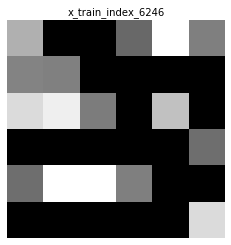

In [118]:
function_call(x_train_pred, y_train_pred, dataset='train', call_type='pred')

In [119]:
function_call(x_test_pred, y_test_pred, dataset='test', call_type='pred')






  0%|          | 0/51992 [00:00<?, ?it/s]




  0%|          | 4/51992 [00:00<22:25, 38.64it/s]




  0%|          | 8/51992 [00:00<22:12, 39.02it/s]




  0%|          | 12/51992 [00:00<22:02, 39.30it/s]




  0%|          | 16/51992 [00:00<21:56, 39.49it/s]




  0%|          | 20/51992 [00:00<22:06, 39.17it/s]




  0%|          | 24/51992 [00:00<22:31, 38.46it/s]




  0%|          | 28/51992 [00:00<22:37, 38.29it/s]




  0%|          | 32/51992 [00:00<22:31, 38.45it/s]




  0%|          | 37/51992 [00:00<21:51, 39.62it/s]




  0%|          | 42/51992 [00:01<21:16, 40.70it/s]




  0%|          | 46/51992 [00:01<21:24, 40.45it/s]




  0%|          | 50/51992 [00:01<21:37, 40.04it/s]




  0%|          | 54/51992 [00:01<21:39, 39.96it/s]




  0%|          | 58/51992 [00:01<22:08, 39.09it/s]




  0%|          | 62/51992 [00:01<22:36, 38.29it/s]




  0%|          | 66/51992 [00:01<22:44, 38.07it/s]




  0%|          | 70/51992 [00:01<22:38, 38.22it/s]




  0%|          |

  2%|▏         | 1077/51992 [00:34<23:40, 35.84it/s]




  2%|▏         | 1082/51992 [00:34<22:40, 37.43it/s]




  2%|▏         | 1087/51992 [00:34<21:28, 39.50it/s]




  2%|▏         | 1092/51992 [00:34<20:50, 40.71it/s]




  2%|▏         | 1097/51992 [00:34<21:01, 40.34it/s]




  2%|▏         | 1102/51992 [00:35<21:00, 40.37it/s]




  2%|▏         | 1107/51992 [00:35<21:13, 39.96it/s]




  2%|▏         | 1112/51992 [00:35<21:05, 40.22it/s]




  2%|▏         | 1117/51992 [00:35<21:12, 39.99it/s]




  2%|▏         | 1122/51992 [00:35<21:08, 40.11it/s]




  2%|▏         | 1127/51992 [00:35<21:31, 39.38it/s]




  2%|▏         | 1131/51992 [00:35<21:32, 39.34it/s]




  2%|▏         | 1135/51992 [00:35<21:36, 39.22it/s]




  2%|▏         | 1139/51992 [00:35<21:30, 39.41it/s]




  2%|▏         | 1143/51992 [00:36<21:35, 39.26it/s]




  2%|▏         | 1148/51992 [00:36<21:21, 39.67it/s]




  2%|▏         | 1152/51992 [00:36<21:23, 39.61it/s]




  2%|▏         | 1156/51992 [00

KeyboardInterrupt: 